In [1]:
!pip install datasets
!pip install torchmetrics
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install transformers[torch]
!pip install torcheval
import nltk
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# connect to google drive for getting dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
from torch.nn import functional as F
from torcheval.metrics import  MulticlassF1Score, MulticlassAccuracy
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate(model, data_loader, f1_metric, acc_metric):
    model.eval()
    for X, y in data_loader:
      y_hat = model.inference(X)
      f1_metric.update(y_hat.view(-1), y)
      acc_metric.update(y_hat.view(-1), y)
    f1_score = f1_metric.compute().item()
    acc_score = acc_metric.compute().item()
    f1_metric.reset()
    acc_metric.reset()
    return f1_score, acc_score

def plot_curve(train_loss_list, test_acc_list, test_f1_list):
    X = range(len(train_loss_list))
    plt.xlabel("epoch")
    plt.title("Emofilm system peformance")
    plt.plot(train_loss_list, label="train_loss")
    plt.plot(test_acc_list, label="test_acc")
    plt.plot(test_f1_list, label="test_f1")
    plt.legend()
    plt.show()
    print(f"the final accuracy is {test_acc_list[-1]}")
    print(f"the final f1 score is {test_f1_list[-1]}")

class Trainer:
  def __init__(self, train_data, test_data, model, epoch=100, lr=0.005, batch_size = 64, optim=AdamW, device="cuda" if torch.cuda.is_available() else "cpu"):
      self.train_data = train_data
      self.test_data = test_data
      self.device = device
      self.model = model.to(self.device)
      self.optimizer = optim(self.model.parameters(), lr=lr, eps = 1e-8)
      self.epoch = epoch
      self.batch_size = batch_size
      self.lr = lr
      self.f1 =  MulticlassF1Score(num_classes=self.model.get_number_classes(), average="macro").to(self.device)
      self.acc = MulticlassAccuracy().to(self.device)

  def lm_collate_fn(self, batch, tokenize_fn):
      batch_text = [row["text"] for row in batch]
      batch_label = [row["label"] for row in batch]
      # batch tokenize input text
      tokenize_feature = tokenize_fn(batch_text)
      tokenize_feature["input_ids"] = tokenize_feature["input_ids"].long().to(self.device)
      tokenize_feature["attention_mask"] = tokenize_feature["attention_mask"].long().to(self.device)
      return tokenize_feature, torch.tensor(batch_label).long().to(self.device)

  @torch.no_grad()
  def evaluate_model(self):
      self.model.eval()
      return evaluate(self.model, self.test_dataloader, self.f1, self.acc)

  def train(self):
      self.train_dataloader = DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=lambda batch: self.lm_collate_fn(batch, tokenize_fn=self.model.tokenized_input))
      self.test_dataloader = DataLoader(self.test_data, batch_size=32, collate_fn=lambda batch: self.lm_collate_fn(batch, tokenize_fn=self.model.tokenized_input))
      train_loss_list = []
      test_acc_list = []
      test_f1_list = []
      for i in range(self.epoch):
        train_loss = 0
        n_points = 0
        for X,y in self.train_dataloader:
          # print(y)
          self.model.train(True)
          loss, logits = self.model.get_loss(X,y)
          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          train_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
          self.optimizer.step()
          self.optimizer.zero_grad()
          n_points += 1
        print(train_loss/n_points)
        train_loss_list.append(train_loss/n_points)
        test_f1, test_acc = self.evaluate_model()
        test_f1_list.append(test_f1)
        test_acc_list.append(test_acc)
      # plot graph
      plot_curve(train_loss_list, test_acc_list, test_f1_list)
      return self.model, train_loss_list, test_acc_list, test_f1_list

In [ ]:
from model.system_factory import SystemFactory
from utils.datafactory import DataFactory
import torch.nn as nn
from torch.optim import AdamW
import pandas as pd

# get dataset
data_filepath = "/content/drive/MyDrive/Colab Notebooks/combined_data.csv"
try:
    train_data, test_data = DataFactory(data_filepath).train_test_split(train_ratio=0.8, n_data=80000)
except Exception as e:
  print(e)


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

0.2771825015743781
0.17499517478081594
0.1708940556358946


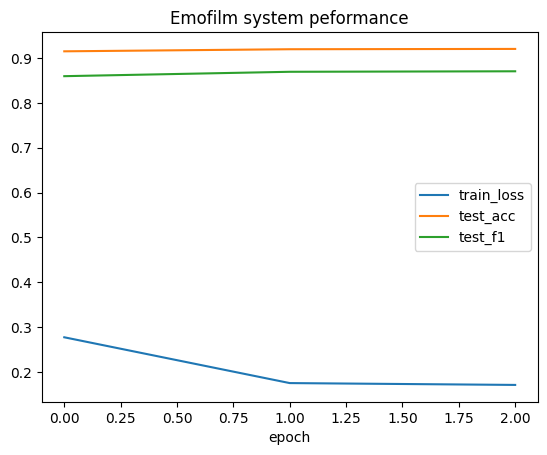

the final accuracy is 0.9205465912818909
the final f1 score is 0.8706521987915039


(EmoFilmSystem(
   (feature_extractor): GPT2Extractor(
     (model): GPT2Model(
       (wte): Embedding(50257, 1024)
       (wpe): Embedding(1024, 1024)
       (drop): Dropout(p=0.1, inplace=False)
       (h): ModuleList(
         (0-23): 24 x GPT2Block(
           (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
           (attn): GPT2Attention(
             (c_attn): Conv1D()
             (c_proj): Conv1D()
             (attn_dropout): Dropout(p=0.1, inplace=False)
             (resid_dropout): Dropout(p=0.1, inplace=False)
           )
           (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
           (mlp): GPT2MLP(
             (c_fc): Conv1D()
             (c_proj): Conv1D()
             (act): NewGELUActivation()
             (dropout): Dropout(p=0.1, inplace=False)
           )
         )
       )
       (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     )
   )
   (classifier): Classifier(
     (sigmod): Sigmoid()
     (softmax):

In [ ]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<10000>"
# os.environ["CUDA_MODULE_LOADING"] = "LAZY"
# default using gpu
torch.manual_seed(10)
trainer_config = {
    "epoch": 3,
    "lr":2e-5,
    "batch_size": 16,
    "optim": AdamW,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

system_config = {
    "extractor_config":{"pre_train_model_name":"gpt2-medium",
                        "train_extractor":True},
    "classifier_config":{"number_classes":3,
                         "hidden_units":[32]},
    "Lossfn":nn.CrossEntropyLoss,
    "max_length":128
}
# initialize system
emofilmsystem = SystemFactory.produce_system(**system_config)
# initialize trainer
trainer = Trainer(train_data=train_data, test_data=test_data, model=emofilmsystem, **trainer_config)
trainer.train()


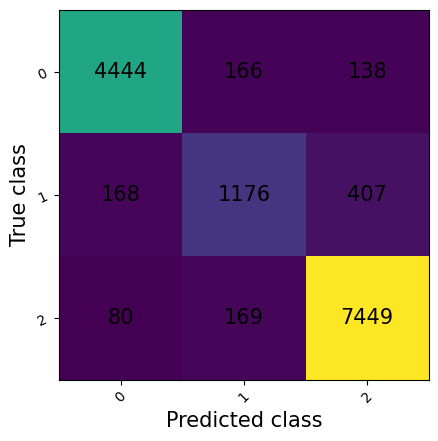

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix

cm = MulticlassConfusionMatrix(num_classes=3).to(trainer.device)
test_dataloader = DataLoader(trainer.test_data, batch_size=32, collate_fn=lambda batch: trainer.lm_collate_fn(batch, tokenize_fn=trainer.model.tokenized_input))
for X, y in test_dataloader:
  trainer.model.eval()
  y_hat = trainer.model.inference(X)
  cm.update(y_hat.view(-1), y)
fig_, ax_ = cm.plot()

In [ ]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<10000>"
# os.environ["CUDA_MODULE_LOADING"] = "LAZY"
# default using gpu
torch.manual_seed(10)
trainer_config = {
    "epoch": 3,
    "lr":2e-5,
    "batch_size": 16,
    "optim": AdamW,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

system_config = {
    "extractor_config":{"pre_train_model_name":"gpt2-large",
                        "train_extractor":True},
    "classifier_config":{"number_classes":3,
                         "hidden_units":[32]},
    "Lossfn":nn.CrossEntropyLoss,
    "max_length":128
}
# initialize system
emofilmsystem = SystemFactory.produce_system(**system_config)
# initialize trainer
trainer = Trainer(train_data=train_data, test_data=test_data, model=emofilmsystem, **trainer_config)
trainer.train()

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

OutOfMemoryError: ignored

In [ ]:
# PATH = "/content/drive/MyDrive/Colab Notebooks/filmEmo.pth"
# torch.save(trainer.model.cpu(), PATH)
from torchmetrics.classification import MulticlassConfusionMatrix

cm = MulticlassConfusionMatrix(num_classes=3).to(trainer.device)
test_dataloader = DataLoader(trainer.test_data, batch_size=32, collate_fn=lambda batch: trainer.lm_collate_fn(batch, tokenize_fn=trainer.model.tokenized_input))
for X, y in test_dataloader:
  trainer.model.eval()
  y_hat = trainer.model.inference(X)
  cm.update(y_hat.view(-1), y)
fig_, ax_ = cm.plot()